In [1]:
import string
import re
from numpy import array, argmax, random, take, argmax
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.utils import pad_sequences
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
def read_text(filename):
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    file.close()
    return text

In [3]:
def to_line(text):
    sentences = text.strip().split('\n')
    sentences = [i.split('\t') for i in sentences]
    return sentences

In [4]:
data = read_text("/content/deu.txt")
ger_eng = to_line(data)

In [5]:
ger_eng = array(ger_eng)
ger_eng = ger_eng[:50000,:]

In [6]:
eng_lang = []
ger_lang = []

In [7]:
#sentence lengths
for i in ger_eng[:, 0]:
    eng_lang.append(len(i.split()))
for i in ger_eng[:, 1]:
    ger_lang.append(len(i.split()))

In [8]:
length_df = pd.DataFrame({'English': eng_lang, 'German': ger_lang})

In [9]:
print(eng_lang)
print(ger_lang)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 

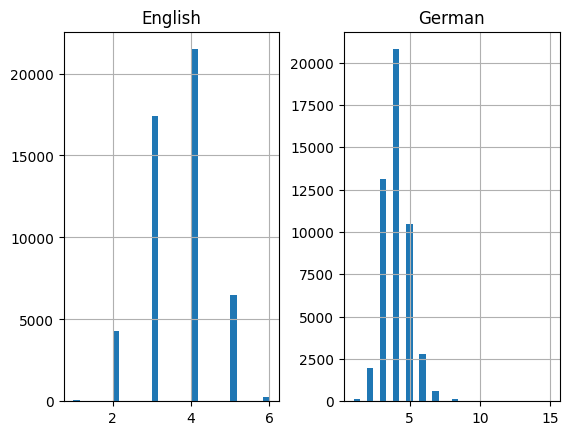

In [10]:
length_df.hist(bins=30)
plt.show()

In [11]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [12]:
#English Tokenizer
eng_tokenizer = tokenization(ger_eng[:, 0])
english_vocab_size = len(eng_tokenizer.word_index)+1
eng_length = 8
print("English vocabulary size: ", english_vocab_size)

English vocabulary size:  6091


In [13]:
#German Tokenizer
ger_tokenizer = tokenization(ger_eng[:, 1])
german_vocab_size = len(ger_tokenizer.word_index)+1
ger_length = 8
print("German vocabulary size: ", german_vocab_size)

German vocabulary size:  10033


In [14]:
def encode_sequence(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ger_eng, test_size=0.2, random_state=12)

In [16]:
trainX = encode_sequence(ger_tokenizer, ger_length, train[:, 1])
trainY = encode_sequence(eng_tokenizer, eng_length, train[:, 0])

In [17]:
testX = encode_sequence(ger_tokenizer, ger_length, test[:, 1])
testY = encode_sequence(eng_tokenizer, eng_length, test[:, 0])

In [18]:
#build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(input_dim=in_vocab, output_dim=units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [19]:
from keras.losses import SparseCategoricalCrossentropy

In [20]:
model = build_model(german_vocab_size, english_vocab_size, ger_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss=SparseCategoricalCrossentropy())

In [21]:
filename = "model.a1.12_aditya"
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [22]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=3, batch_size=512,
                    validation_split=0.1,
                    callbacks=[checkpoint], verbose=1)

Epoch 1/3
71/71 [==============================] - ETA: 0s - loss: 3.2643
Epoch 1: val_loss improved from inf to 2.89333, saving model to model.a1.12_aditya


71/71 [==============================] - 350s 5s/step - loss: 3.2643 - val_loss: 2.8933
Epoch 2/3
71/71 [==============================] - ETA: 0s - loss: 2.6711
Epoch 2: val_loss improved from 2.89333 to 2.60939, saving model to model.a1.12_aditya


71/71 [==============================] - 344s 5s/step - loss: 2.6711 - val_loss: 2.6094
Epoch 3/3
71/71 [==============================] - ETA: 0s - loss: 2.4739
Epoch 3: val_loss improved from 2.60939 to 2.43932, saving model to model.a1.12_aditya


71/71 [==============================] - 353s 5s/step - loss: 2.4739 - val_loss: 2.4393


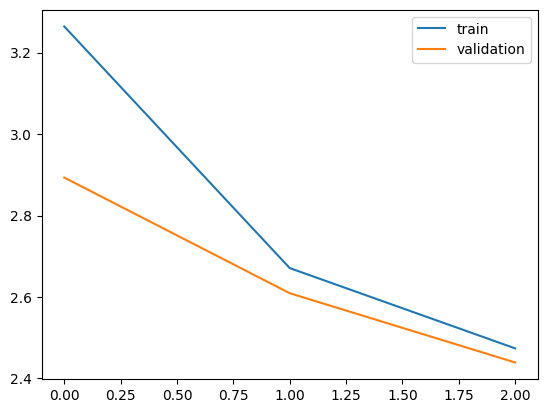

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.show()

In [24]:
model = load_model('model.a1.12_aditya')
preds = model.predict(testX.reshape((testX.shape[0], testX.shape[1])))

313/313 [==============================] - 47s 141ms/step


In [25]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [26]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(argmax(i[j]), eng_tokenizer)
        if j > 0:
            if t == get_word(argmax(i[j-1]), eng_tokenizer) or t is None:
                temp.append('')
            else:
                temp.append(t)
        else:
            if t is None:
                temp.append('')
            else:
                temp.append(t)
    preds_text.append(' '.join(temp))

In [27]:
pred_df = pd.DataFrame({'actual': test[:,0], 'predicted': preds_text})

In [28]:
pd.set_option('display.max_colwidth', 200)

In [29]:
pred_df.head(15)

,actual,predicted
0,Tom can't help you.,tom was tom
1,Tom knows.,tom was
2,Tom loves you.,tom was
3,Open the door.,the is
4,We don't have to go.,we you
5,"It's your turn, Tom.",it you
6,Didn't Tom kiss Mary?,tom was a
7,The wind is howling.,the is
8,He knows me well.,he a
9,Tom has a toothache.,tom is


In [30]:
pred_df.tail(15)

,actual,predicted
9985,He walked quietly.,he the is
9986,Tom is agitated.,tom is
9987,Tom left the room.,tom was a
9988,I picked up a coin.,i have a
9989,We're not needed.,you
9990,I speak very fast.,i was
9991,You're so dirty.,is
9992,Tom obeyed.,tom was a
9993,Why didn't you eat?,what you
9994,I am dead tired.,i'm was
